# Image Classification: Cats and Dogs



Kaggle competition link: https://www.kaggle.com/competitions/dog-vs-cat-classification


## Table of Contents


### Exploring the Data
- Directory  
- Removing Corrupted Images  
- Dataset Sizes  
- Sample Images  

### Model Training and Evaluation
- Simple CNN  
  - Hyperparameter Tuning  
    - Random Search  
    - Bayesian Optimizer  
    - Conclusion  
- Deep CNN  
- Transfer Learning  
  - Fine-Tuning  
- Predictions


### Findings and Challenges


## Exploring the Data

In [1]:
# Link to my Google Drive where we have downloaded the kaggle dataset zip file
! gdown --id 1PVOhNwpAU3Lp-SOf2BtKVhkvfLrLbacF

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PVOhNwpAU3Lp-SOf2BtKVhkvfLrLbacF
From (redirected): https://drive.google.com/uc?id=1PVOhNwpAU3Lp-SOf2BtKVhkvfLrLbacF&confirm=t&uuid=10497446-9858-4951-bf9b-e9214c7c27e9
To: /content/dog-vs-cat-classification.zip
100% 768M/768M [00:12<00:00, 63.0MB/s]


In [2]:
# Unzip the file. We found this to be the fastest way to load this large dataset into colab
!unzip -oq /content/dog-vs-cat-classification.zip -d /content/

### Directory

    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    test/
        000001.jpg
        000002.jpg
        ...


### Removing Corrupted Images

In [3]:
import os
from PIL import Image

TRAIN_DIR = '/content/dog-vs-cat-classification/train'
TEST_DIR = '/content/dog-vs-cat-classification/test'

def check_corrupted_images(directory):
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if the image can be opened
            except Exception as e:
                print(f"Corrupted file found: {file_path} - Error: {e}")
                corrupted_files.append(file_path)
    return corrupted_files

# Check train and test directories
corrupted_train = check_corrupted_images(TRAIN_DIR)
corrupted_test = check_corrupted_images(TEST_DIR)

# Print summary
print(f"Total corrupted files in train: {len(corrupted_train)}")
print(f"Total corrupted files in test: {len(corrupted_test)}")

def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except:
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)

# Remove corrupted files
remove_corrupted_images(TRAIN_DIR)


Corrupted file found: /content/dog-vs-cat-classification/train/.DS_Store - Error: cannot identify image file '/content/dog-vs-cat-classification/train/.DS_Store'
Total corrupted files in train: 1
Total corrupted files in test: 0
Removing corrupted file: /content/dog-vs-cat-classification/train/.DS_Store


### Dataset Sizes

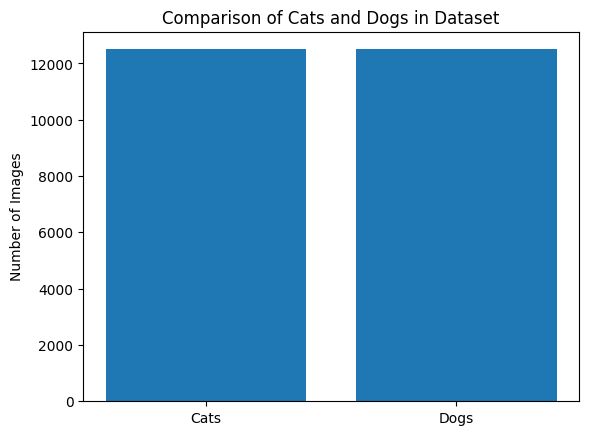

The number of cats in our training set are 12500
The number of dogs in our training set are 12500
The dataset is perfectly balanced!


In [4]:
CAT_DIR = '/content/dog-vs-cat-classification/train/cats'  # Path to training set cat images
DOG_DIR = '/content/dog-vs-cat-classification/train/dogs'  # Path to training set dog images

import os
num_cats = len([f for f in os.listdir(CAT_DIR) if f.lower().endswith('.jpg')])
num_dogs = len([f for f in os.listdir(DOG_DIR) if f.lower().endswith('.jpg')])

import matplotlib.pyplot as plt

# Data for the bar plot
categories = ["Cats", "Dogs"]
counts = [num_cats, num_dogs]

# Create bar plot
plt.bar(categories, counts)

# Labels and title
plt.ylabel("Number of Images")
plt.title("Comparison of Cats and Dogs in Dataset")

# Show the plot
plt.show()
print("The number of cats in our training set are", num_cats)
print("The number of dogs in our training set are", num_dogs)
print("The dataset is perfectly balanced!")

### Sample Images

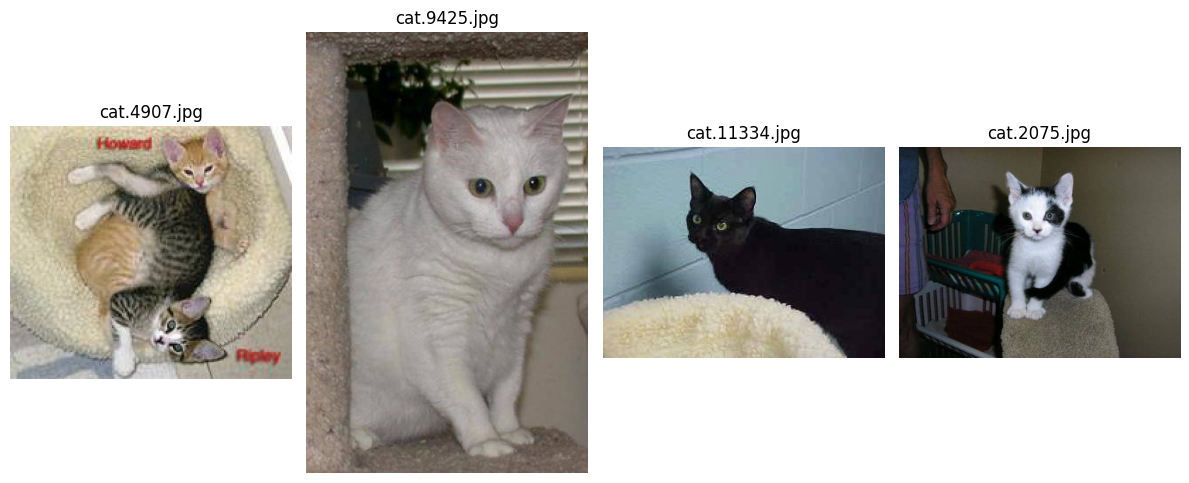

In [6]:
import cv2
import random

# Define dataset path
NUM_IMAGES = 4  # Number of images to display

# Function to get a list of random image paths
def get_images(dir, num_images):
    images = os.listdir(dir)
    selected_images = random.sample(images, min(len(images), num_images))
    return [os.path.join(dir, img) for img in selected_images]

# Load cat images
cat_image_paths = get_images(CAT_DIR, NUM_IMAGES)
dog_image_paths = get_images(DOG_DIR, NUM_IMAGES)

# Plot images in a grid
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(cat_image_paths)):
    img_path = cat_image_paths[i]
    img_name = os.path.basename(cat_image_paths[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    axes[i].imshow(img)
    axes[i].set_title(img_name)
    axes[i].axis("off")

# Hide any unused subplots
for i in range(len(cat_image_paths), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


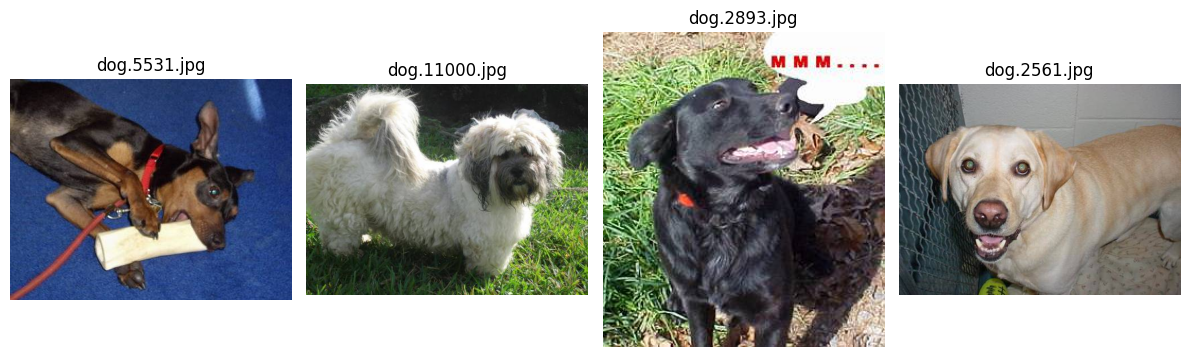

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(dog_image_paths)):
    img_path = dog_image_paths[i]
    img_name = os.path.basename(dog_image_paths[i])

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    axes[i].imshow(img)
    axes[i].set_title(img_name)
    axes[i].axis("off")

# Hide any unused subplots
for i in range(len(dog_image_paths), len(axes)):
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## Model Training and Evaluation

For the dog vs. cat classification problem, we selected a Convolutional Neural Network (CNN) because CNNs are specifically designed for image recognition tasks

**Why CNNs Are the Best Choice:**

1. Traditional machine learning models (e.g., logistic regression, SVM, decision trees) require manual feature extraction. However, CNNs automatically learn image features like edges and contours, textures and shapes, and complex structures. This eliminates the need for handcrafted features, making CNNs more efficient.

2. Spatial Hierarchy of Features
CNNs preserve the spatial structure of images. Unlike fully connected networks (MLPs), which flatten images and lose spatial relationships, CNNs use local receptive fields to scan small portions of the image at a time,
shared weights (filters) that detect patterns regardless of position,
and pooling layers that retain the most important features while reducing computation.

3. CNNs generalize well even when the image is shifted, rotated, or zoomed, the background is complex or noisy, and different dog and cat breeds have similar features.

### Simple CNN

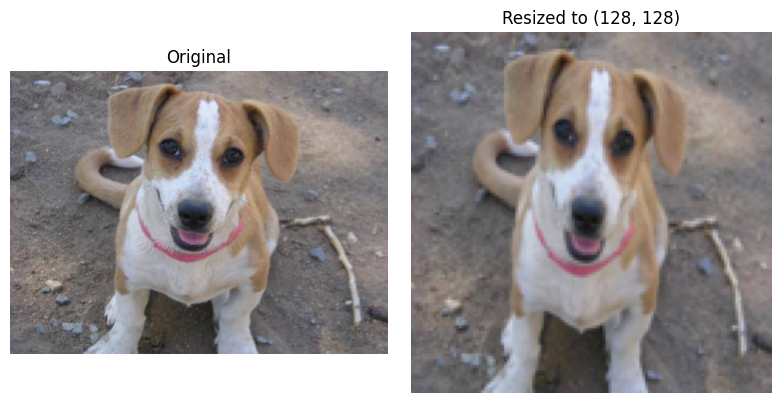

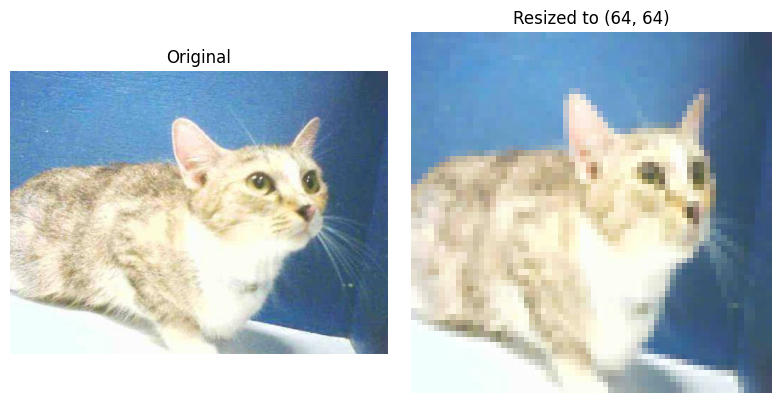

In [8]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_random_resized_image(data_dir="train", target_size=(224, 224), show=True):
    """
    Randomly selects an image from the 'cats' or 'dogs' subfolder of the given data directory,
    resizes it, and optionally displays both original and resized images.

    Args:
        data_dir (str): Path to the main training directory (should contain 'cats/' and 'dogs/').
        target_size (tuple): Target size for the resized image (width, height).
        show (bool): Whether to display the original and resized images.

    Returns:
        original (PIL.Image): Original image.
        resized (PIL.Image): Resized image.
        path (str): Path to the randomly selected image.
    """
    categories = ["cats", "dogs"]
    chosen_category = random.choice(categories)
    category_path = os.path.join(data_dir, chosen_category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise FileNotFoundError(f"No images found in {category_path}")

    chosen_file = random.choice(image_files)
    image_path = os.path.join(category_path, chosen_file)

    original = Image.open(image_path)
    resized = original.resize(target_size)

    if show:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(original)
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(resized)
        axs[1].set_title(f"Resized to {target_size}")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

    return original, resized, image_path

orig, resized, path = show_random_resized_image(TRAIN_DIR, target_size=(128, 128))
orig, resized, path = show_random_resized_image(TRAIN_DIR, target_size=(64, 64))



After the basic data cleaning on Corrupted Images, we did the data processing as well. Basically, we resized all the images from the training set to 128x128 pixels. The 128-image size is chosen as a balance between retaining important details, optimizing GPU efficiency (power of 2 pixel sizes are most efficient), and allowing larger batch sizes for faster training. As you can see, if we choose 64x64, then the image will be blurred.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(input_shape=(128, 128, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_cnn_model()

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Training the model

checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 20001 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5958 - loss: 0.6540
Epoch 1: saving model to model_epoch_01.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.5960 - loss: 0.6538 - val_accuracy: 0.7550 - val_loss: 0.5231
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7556 - loss: 0.5056
Epoch 2: saving model to model_epoch_02.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.7556 - loss: 0.5056 - val_accuracy: 0.7966 - val_loss: 0.4434
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8135 - loss: 0.4106
Epoch 3: saving model to model_epoch_03.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8136 - loss: 0.4105 - val_accuracy: 0.8140 - val_loss: 0.4218
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8483 - loss: 0.3505
Epoch 4: saving model to model_epoch_04.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8483 - loss: 0.3505 - val_accuracy: 0.8350 - val_loss: 0.3896
Epo

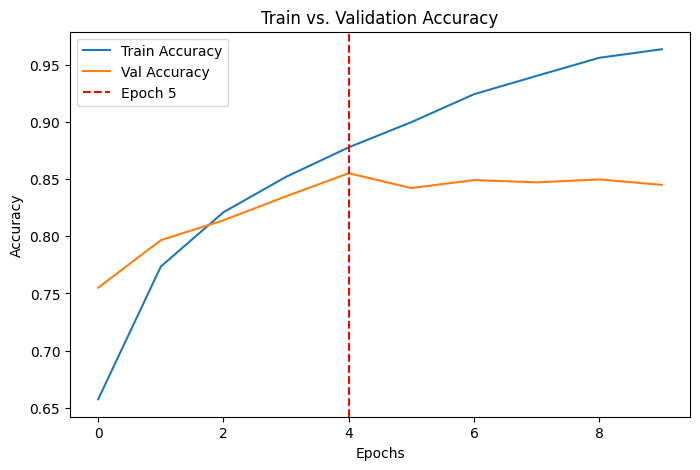

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

# Vertical line at epoch 5
plt.axvline(x=4, color='red', linestyle='--', label='Epoch 5')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()


In [11]:
from tensorflow.keras.models import load_model

best_model = load_model('model_epoch_04.keras')


We stopped early at epoch 5 because after this epoch our model starts to overfit. At this epoch our training accuracy is 88% and validation 86%.


#### Hyperparameter Tuning

Hyperparameter tuning for a simple CNN involves optimizing key parameters like filter sizes, number of layers, learning rate, and dropout rate to boost model performance. Two common strategies are Random Search, which samples combinations randomly from a predefined range, and Bayesian Optimization, which builds a probabilistic model of performance and intelligently explores promising regions of the search space. Random Search is quick and easy but inefficient in high dimensions, while Bayesian Optimization is more strategic and sample-efficient, often yielding better results with fewer trials. Tools like Keras Tuner streamline both methods for practical use in CNN tuning.


##### Random Search

We applied Random Search using Keras Tuner. We defined a search space including key hyperparameters such as the number of filters in convolutional layers, kernel size, number of dense units, dropout rate, and learning rate. Rather than exhaustively testing all combinations, Random Search randomly sampled from these ranges over a fixed number of trials. For each configuration, the tuner trained the model and evaluated its performance on the validation set. This allowed us to efficiently identify a strong hyperparameter setup without the computational cost of a full grid search.

Trial 3 Complete [00h 00m 18s]
val_accuracy: 0.5249999761581421

Best val_accuracy So Far: 0.6270833611488342
Total elapsed time: 00h 01m 07s
Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5857 - loss: 0.8502
Epoch 1: val_accuracy improved from -inf to 0.58460, saving model to best_deep_tuned_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.5858 - loss: 0.8500 - val_accuracy: 0.5846 - val_loss: 0.6582 - learning_rate: 0.0010
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7021 - loss: 0.5764
Epoch 2: val_accuracy improved from 0.58460 to 0.73880, saving model to best_deep_tuned_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.7022 - loss: 0.5764 - val_accuracy: 0.7388 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7910 - loss: 0.4475
Epoch 3: val_accuracy improved from 0.73880 to 0.77160, saving model to best_deep_tuned_model.keras
626/626 ━━━━━━

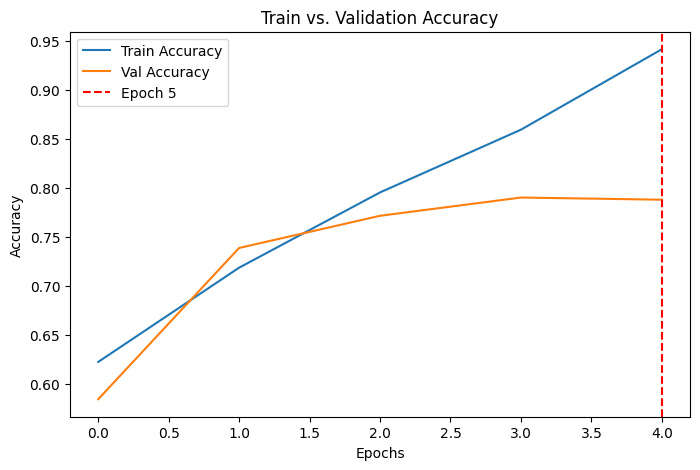

In [20]:
#simple CNN hyperparameter tuning with random search
# Limit to subset(2000) for tuning
!pip install keras-tuner --quiet
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence

class SubsetGenerator(Sequence):
    def __init__(self, generator, num_samples):
        self.generator = generator
        self.num_samples = num_samples
        self.batch_size = generator.batch_size

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, index):
        return self.generator[index]

    def on_epoch_end(self):
        self.generator.on_epoch_end()

small_train_gen = SubsetGenerator(train_generator, 2000)
small_val_gen = SubsetGenerator(validation_generator, 500)
def model_builder(hp):
    model = keras.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filter', values=[32, 64]),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filter', values=[64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Reduce search space
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=3,
    directory='kt_tuning',
    project_name='quick_tune'
)

# Fast search
tuner.search(small_train_gen, validation_data=small_val_gen, epochs=3)

# Train best model on full data later
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Learning rate scheduler to reduce LR on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1
)

#Save best model
checkpoint = ModelCheckpoint(
    'best_deep_tuned_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Re-train best model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # can go higher with early stopping in place
    callbacks=[early_stop, reduce_lr, checkpoint]
)

#Plot results
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(x=4, color='red', linestyle='--', label='Epoch 5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

##### Bayesian Optimizer

To further optimize our simple CNN, we employed Bayesian Optimization using Keras Tuner. Unlike Random Search, which samples blindly, Bayesian Optimization builds a probabilistic model of the objective function and uses past trial results to guide the next search points. This allows it to intelligently explore the hyperparameter space and converge on high-performing configurations with fewer trials. We defined a search space that includes convolutional filters, kernel sizes, dense units, dropout rate, and learning rate. The tuner iteratively refined its estimates, balancing exploration and exploitation to efficiently find the best-performing model.

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.6208333373069763

Best val_accuracy So Far: 0.6916666626930237
Total elapsed time: 00h 04m 13s
Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6034 - loss: 0.6478
Epoch 1: val_accuracy improved from -inf to 0.74600, saving model to best_simple_cnn_bayes.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.6035 - loss: 0.6477 - val_accuracy: 0.7460 - val_loss: 0.5135 - learning_rate: 1.0000e-04
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7507 - loss: 0.5049
Epoch 2: val_accuracy improved from 0.74600 to 0.78100, saving model to best_simple_cnn_bayes.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.7507 - loss: 0.5049 - val_accuracy: 0.7810 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7982 - loss: 0.4406
Epoch 3: val_accuracy improved from 0.78100 to 0.78780, saving model to best_simple_cnn_bayes.keras
626/6

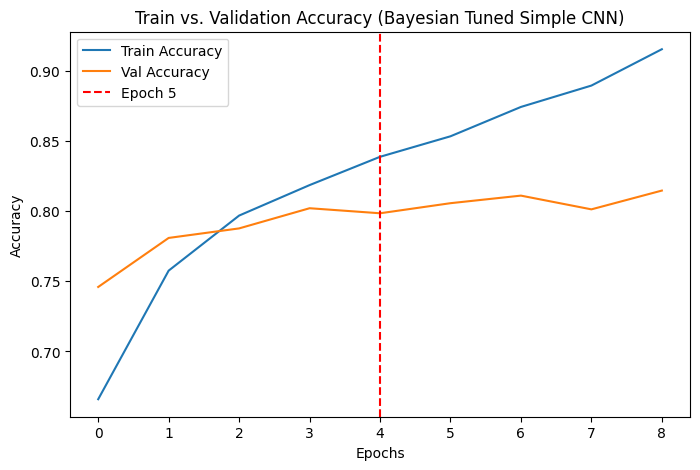

In [21]:
#hyperparameter tuning with bayesian search
import keras_tuner as kt
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 2. Define model builder for Simple CNN
def model_builder(hp):
    model = keras.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filter', values=[32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filter', values=[64, 128, 256]),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3. Subset generator to speed up tuning
from tensorflow.keras.utils import Sequence

class SubsetGenerator(Sequence):
    def __init__(self, generator, num_samples):
        self.generator = generator
        self.num_samples = num_samples
        self.batch_size = generator.batch_size

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, index):
        return self.generator[index]

    def on_epoch_end(self):
        self.generator.on_epoch_end()

small_train_gen = SubsetGenerator(train_generator, 2000)
small_val_gen = SubsetGenerator(validation_generator, 500)

# 4. Run Bayesian Optimization
tuner = BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # increase to 15–20 for deeper searches
    seed=42,
    directory='kt_tuning',
    project_name='simple_cnn_bayes'
)

tuner.search(small_train_gen, validation_data=small_val_gen, epochs=3)

# 5. Callbacks for final training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_simple_cnn_bayes.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 6. Final training on full data
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# 7. Plot training results
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(x=4, color='red', linestyle='--', label='Epoch 5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy (Bayesian Tuned Simple CNN)')
plt.legend()
plt.show()


##### Conclusion

We tried to use Hyperparameter tuning to improve model performance, we applied both Random Search and Bayesian Optimization on Simple CNN, but they both face significant challenges.

Random Search tends to overfit. Select architecture with too many filters, oversized dense layers, lead to near-perfect training accuracy but poor validation performance. EarlyStopping often caused the test to halt at epoch 3, which was too early to discover optimal parameter combinations.

Bayesian Optimization had the same overfitting pattern; EarlyStopping cut off slower learning configurations that may have better performance. Both methods used a tiny subset of just 2,000 images, which didn't reflect the full dataset & led to poor generalization.
However otherwise it will take too long to train.

### Deep CNN

In [12]:
def build_deep_cnn_model(input_shape=(128, 128, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_deep_cnn_model()

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Training the model

checkpoint = ModelCheckpoint(
    filepath='model_deep_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Found 20001 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5860 - loss: 0.8235
Epoch 1: saving model to model_deep_epoch_01.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.5861 - loss: 0.8234 - val_accuracy: 0.5892 - val_loss: 0.7277
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7244 - loss: 0.5371
Epoch 2: saving model to model_deep_epoch_02.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.7244 - loss: 0.5371 - val_accuracy: 0.7580 - val_loss: 0.4891
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8251 - loss: 0.3928
Epoch 3: saving model to model_deep_epoch_03.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 84s 76ms/step - accuracy: 0.8251 - loss: 0.3927 - val_accuracy: 0.8454 - val_loss: 0.3468
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8764 - loss: 0.2911
Epoch 4: saving model to model_deep_epoch_04.keras
626/62

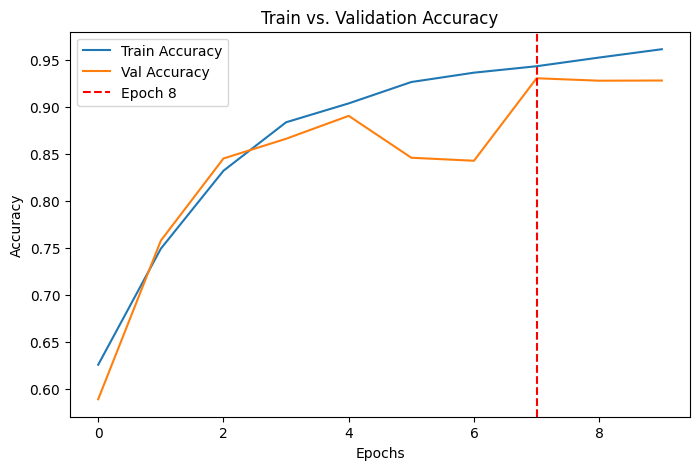

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

# Vertical line at epoch 8
plt.axvline(x=7, color='red', linestyle='--', label='Epoch 8')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

In [14]:
best_deep_model = load_model('model_deep_epoch_08.keras')


We stopped early at epoch 7 since this is the sweet spot where training and validation accuracy are roughly the same. Our training accuracy is 95% and validation 93% which is an improvement from our simple CNN.


### Transfer Learning

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_vgg16_model(input_shape=(224, 224, 3)):
    # Load the VGG16 base model (without top classifier layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


# Use preprocess_input for VGG16
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


# Build and train the model

model = build_vgg16_model()

checkpoint = ModelCheckpoint(
    filepath='vgg16_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint]
)

Found 20001 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9434 - loss: 2.6837
Epoch 1: saving model to vgg16_epoch_01.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 149s 216ms/step - accuracy: 0.9435 - loss: 2.6809 - val_accuracy: 0.9792 - val_loss: 0.0739
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9791 - loss: 0.0818
Epoch 2: saving model to vgg16_epoch_02.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.9791 - loss: 0.0818 - val_accuracy: 0.9820 - val_loss: 0.0794
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9814 - loss: 0.0720
Epoch 3: saving model to vgg16_epoch_03.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 132s 210ms/step - accuracy: 0.9814 - loss: 0.0720 - val_accuracy: 0.9784 - val_loss: 0.0874
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9845 - loss: 0.0503
Epoch 4: sa

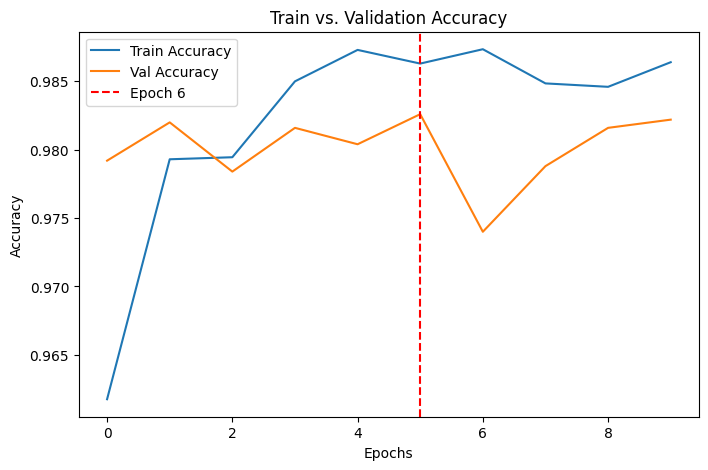

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

# Vertical line at epoch 6
plt.axvline(x=5, color='red', linestyle='--', label='Epoch 6')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

In [17]:
best_vgg_model = load_model('model_deep_epoch_06.keras')


There were no signs of over or underfitting so we just stopped at the epoch that gave us the highest accuracy which was epoch 6. The accuracy we achieved was 98.26%, which made it even more accurate than our deep CNN.





#### Fine-Tuning

In [18]:
# Unfreeze last few layers
base_model = model.layers[0]  # VGG16
base_model.trainable = True

# Fine-tune only the last few layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile and train again
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='unfreezed_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint]
)


Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9873 - loss: 0.0403
Epoch 1: saving model to unfreezed_epoch_01.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 162s 251ms/step - accuracy: 0.9873 - loss: 0.0403 - val_accuracy: 0.9832 - val_loss: 0.0916
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9908 - loss: 0.0198
Epoch 2: saving model to unfreezed_epoch_02.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 155s 247ms/step - accuracy: 0.9908 - loss: 0.0198 - val_accuracy: 0.9846 - val_loss: 0.0903
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9938 - loss: 0.0153
Epoch 3: saving model to unfreezed_epoch_03.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 202s 248ms/step - accuracy: 0.9939 - loss: 0.0153 - val_accuracy: 0.9852 - val_loss: 0.1219
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9945 - loss: 0.0184
Epoch 4: saving model to unfreezed_epoch_04.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 202s 248ms/step - accuracy: 0.9945 - loss: 0.0183 - val_

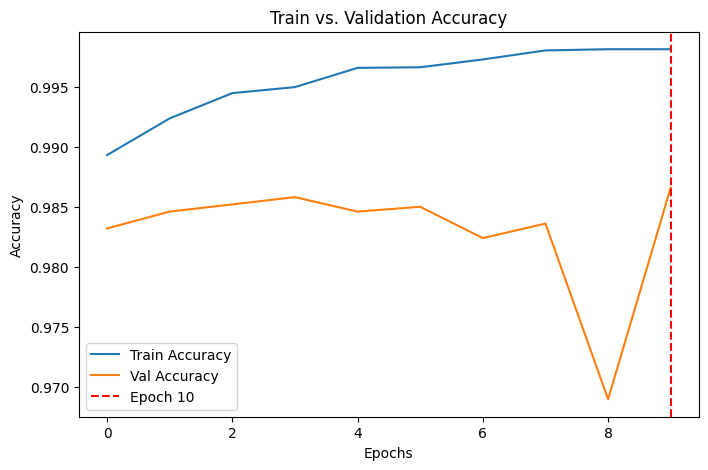

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

# Vertical line at epoch 9
plt.axvline(x=9, color='red', linestyle='--', label='Epoch 10')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
best_tuned_model = load_model('unfreezed_epoch_09.keras')


Again there were no signs of over or underfitting so we just stopped at the epoch that gave us the highest accuracy which was epoch 10. The accuracy we achieved was 98.66%, which is a slight improvement.


### Predictions

In [ ]:
filenames = sorted(os.listdir(TEST_DIR))  # ensure they're in order
df = pd.DataFrame({'filename': filenames})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TEST_DIR,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

predictions = best_vgg16_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()


Found 8000 validated image filenames.
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step


In [ ]:
# Extract image filenames (e.g., 'test_images/000000.jpg' → '000000.jpg')
image_ids = [filename.split('/')[-1] for filename in test_generator.filenames]

# Create DataFrame
results_df = pd.DataFrame({
    'id': image_ids,
    'labels': predicted_labels
})

# Save to CSV
results_df.to_csv('vgg16_predictions.csv', index=False)


## Findings and Challenges

The main challenges were tuning on limited data, short training per trial, and unstable hyperparameter ranges. Overall, manual tuning worked better here, but Bayesian methods could scale better for deeper models or noisier datasets.

When comparing models, our Deep CNN consistently outperformed the Simple CNN across all key metrics — including accuracy, loss, and generalization.

Transfer learning with VGG16 also performed competitively, offering the highest accuracy and reduced overfitting risk due to its pretrained feature extraction. The high accuracy was achieved at the expense of training time.

We used binary cross-entropy as our primary loss function, which worked well for probabilistic binary classification. Accuracy and validation loss — along with early stopping — were effective for monitoring and comparing model quality.

Overall, our conclusions are well-supported by the data. The Deep CNN architecture proved most effective and reliable since it achieved a relatively high accuracy with just 10 minutes of training!